In [1]:
from pathlib import Path
import sys

sys.path.append(str(Path('').absolute().parent))

In [45]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy import sparse
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)
from sklearn.utils.validation import check_is_fitted
from chembl_webresource_client.new_client import new_client

# Paths

In [3]:
ROOT = Path('..')
MODELS_DIR = ROOT / 'models'
DATA_DIR = ROOT / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'

# Load data splits

In [4]:
# TODO: move to utils
def load_data_splits(*, data_dir, split):
    if split not in ['train', 'test']:
        raise ValueError('`split` should be either `train` or `test`')
    
    X = sparse.load_npz(data_dir / split / f'sparse_{split}_X.npz')\
        .toarray()
    y = sparse.load_npz(data_dir / split / f'sparse_{split}_y.npz')\
        .toarray()\
        .squeeze()
    
    return X, y

In [5]:
train_X, train_y = load_data_splits(data_dir=RAW_DATA_DIR, split='train')
test_X, test_y = load_data_splits(data_dir=RAW_DATA_DIR, split='test')

# print shapes to confirm
for split in ['train_X', 'train_y', 'test_X', 'test_y']:
    print('{name}: {shape}'.format(name=split, shape=eval(split).shape))

train_X: (4140, 2048)
train_y: (4140,)
test_X: (1035, 2048)
test_y: (1035,)


# Load best model

In [6]:
best_model_path = MODELS_DIR / 'model_gb.joblib'
model = joblib.load(best_model_path)
check_is_fitted(model)
model

GradientBoostingClassifier(learning_rate=0.3935910935564404, max_depth=14,
                           min_samples_leaf=17, n_estimators=155,
                           random_state=123)

In [7]:
model_tuned_params = dict(
    learning_rate=0.3935911,
    max_depth=14,
    min_samples_leaf=17,
    n_estimators=155,
    random_state=123
)

# Benchmark performance on test set

In [8]:
test_pred = model.predict(test_X)
print('Accuracy on test set: {:.4f}'.format(accuracy_score(test_y, test_pred)))
print(classification_report(test_y, test_pred))

Accuracy on test set: 0.8406
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       324
           1       0.88      0.90      0.89       711

    accuracy                           0.84      1035
   macro avg       0.82      0.81      0.81      1035
weighted avg       0.84      0.84      0.84      1035



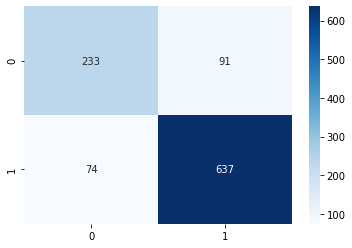

In [9]:
sns.heatmap(confusion_matrix(test_y, test_pred),
            cmap='Blues', annot=True, fmt='d');

# Using SHAP for explanations

In [10]:
def get_top_bits(shap_values, n):
    importances = np.abs(shap_values).mean(0)
    return list(reversed(np.argsort(importances)))[:n]

## On test features

In [11]:
feature_names = [*map(lambda x: 'bit_{}'.format(x),
                      range(test_X.shape[1]))]
explainer = shap.Explainer(model,
                           feature_names=feature_names)
shap_explanation = explainer(train_X)

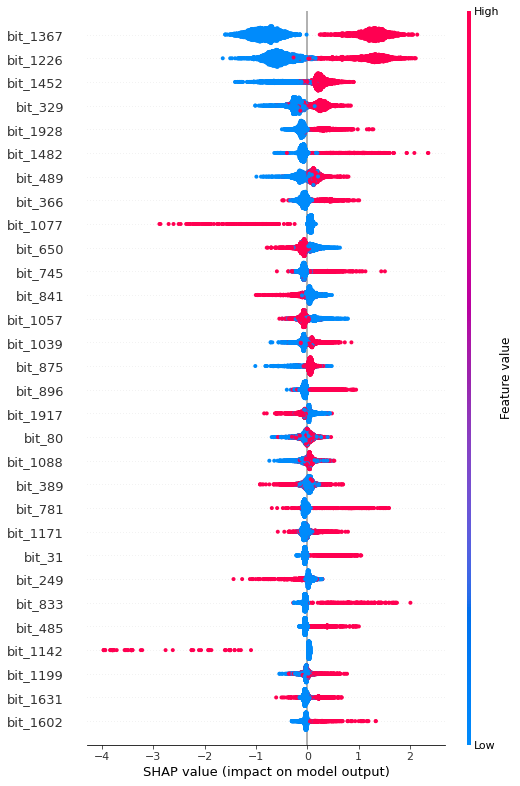

In [12]:
# nummary_plot explaining target class at index 0
shap.summary_plot(shap_explanation, train_X, max_display=30)

### Bar plot
Summarize the effects of features accross all instances

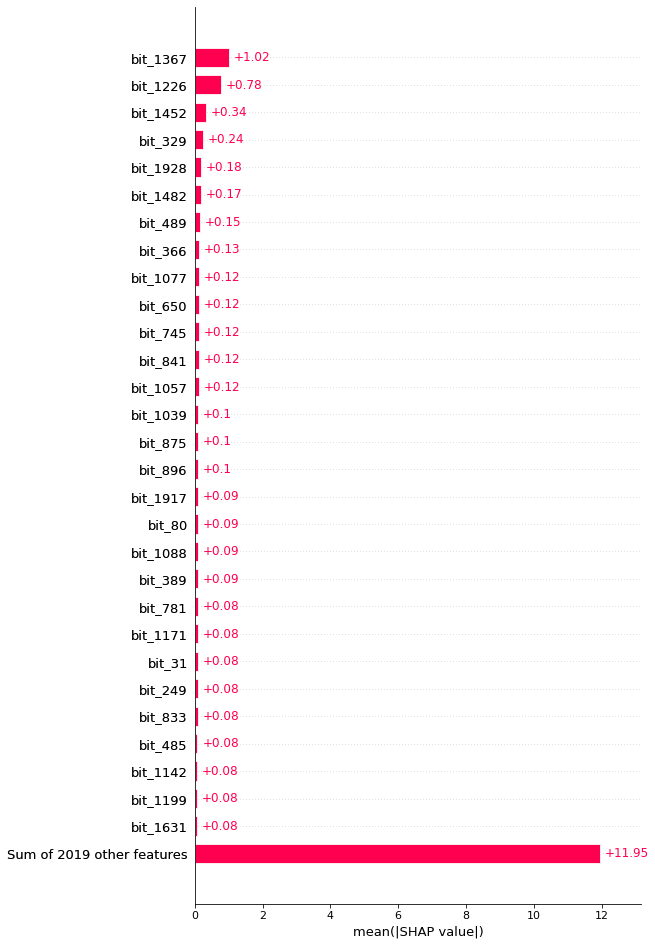

In [13]:
shap.plots.bar(shap_explanation, max_display=30)

As expected from ensembles (specially boosted trees), feature contributions "add up" to get a prediction result. Hence, the overall contribution of each feature tends to be small, and spread across many of them. However, in this scenario we clearly have two features standind out.

In [14]:
top_10_bits = get_top_bits(shap_explanation.values, n=10)
top_10_bits

[1367, 1226, 1452, 329, 1928, 1482, 489, 366, 1077, 650]

# Visualize most important bits as molecule fragments

In [15]:
import json
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import (Draw,
                        Descriptors,
                        AllChem)

In [16]:
df_smiles = pd.read_csv(DATA_DIR / 'egfr_erbB1_smiles.csv', index_col=0)
df_smiles.head()

,chembid,smiles_notation
0,CHEMBL301018,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OC
1,CHEMBL281543,C=CC(=O)Nc1nc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1CCCCN...
2,CHEMBL401930,Cc1cc(N2CCOCC2)cc2[nH]c(-c3c(NC[C@@H](O)c4cccc...
3,CHEMBL274654,Cc1[nH]c(/C=C2\C(=O)Nc3ccccc32)c(C)c1CCC(=O)O
4,CHEMBL382822,COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCC[C@@H]1C...


In [17]:
with open(DATA_DIR / 'bit_info.json', 'r') as file:
    chembl_to_bitinfo = json.load(file)

print('Sample elem from map:')
[{k: v} for k, v in chembl_to_bitinfo.items()][0]

Sample elem from map:


{'CHEMBL301018': {'191': [[10, 1]],
  '216': [[12, 2]],
  '249': [[1, 2], [21, 2]],
  '329': [[10, 2]],
  '366': [[15, 1]],
  '378': [[5, 0], [7, 0]],
  '465': [[13, 2]],
  '489': [[6, 1]],
  '491': [[9, 1]],
  '561': [[16, 1]],
  '673': [[4, 2]],
  '695': [[1, 0], [21, 0]],
  '699': [[14, 1]],
  '708': [[8, 1]],
  '780': [[3, 2]],
  '794': [[8, 2]],
  '841': [[0, 1], [22, 1]],
  '843': [[11, 2]],
  '875': [[3, 1], [19, 1], [17, 1]],
  '888': [[9, 2]],
  '1057': [[0, 0], [22, 0]],
  '1097': [[4, 1]],
  '1152': [[9, 0]],
  '1157': [[18, 2]],
  '1226': [[5, 2]],
  '1245': [[2, 2], [20, 2]],
  '1357': [[18, 1]],
  '1367': [[7, 2]],
  '1380': [[2, 0],
   [4, 0],
   [8, 0],
   [10, 0],
   [13, 0],
   [15, 0],
   [18, 0],
   [20, 0]],
  '1452': [[5, 1], [7, 1]],
  '1488': [[15, 2]],
  '1536': [[1, 1], [21, 1]],
  '1581': [[17, 2]],
  '1648': [[19, 2]],
  '1683': [[16, 0]],
  '1750': [[11, 1], [12, 1]],
  '1810': [[6, 2]],
  '1840': [[13, 1]],
  '1873': [[3, 0], [6, 0], [11, 0], [12, 0], [17,

In [18]:
# funções de conveniência
def get_mol(chembl, df_smiles):
    smiles = df_smiles[df_smiles['chembid'] == chembl].iloc[0,1]
    mol = Chem.MolFromSmiles(smiles)
    return mol

Bit 1367 ----------------------------------------------


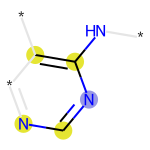

Bit 1226 ----------------------------------------------


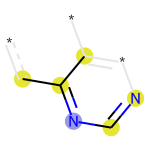

Bit 1452 ----------------------------------------------


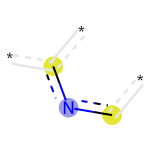

Bit 329 -----------------------------------------------


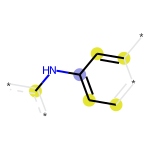

Bit 1928 ----------------------------------------------


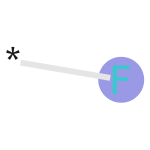

Bit 1482 ----------------------------------------------


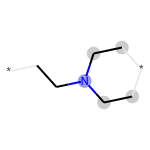

Bit 489 -----------------------------------------------


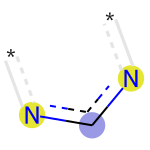

Bit 366 -----------------------------------------------


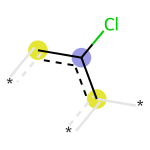

Bit 1077 ----------------------------------------------


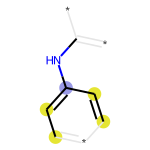

Bit 650 -----------------------------------------------


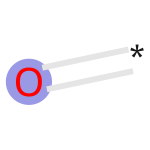

In [19]:
for bit_num in top_10_bits:
    search_bit = str(bit_num)
    print('Bit {}'.format(search_bit), '-'*(50 - len(search_bit)))

    # get bit info corresponding to it
    chemblid, bi = [(_id, bit_info) for _id, bit_info in chembl_to_bitinfo.items()
                    if search_bit in list(bit_info.keys())][0]
    
    search_mol = get_mol(chemblid, df_smiles)
    bit_img = Draw.DrawMorganBit(search_mol, search_bit, bi, useSVG=True)
    display(bit_img)

# Agrupamento considerando apenas principais bits

In [20]:
import hdbscan
import umap
import itertools as it
import math

# TODO

justificar escolha de top 10

Pela quantidade de pontos, visualização utlizando cor e em gráficos separados parece ser mais informativo e interpretável.

### Clusterização

failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!


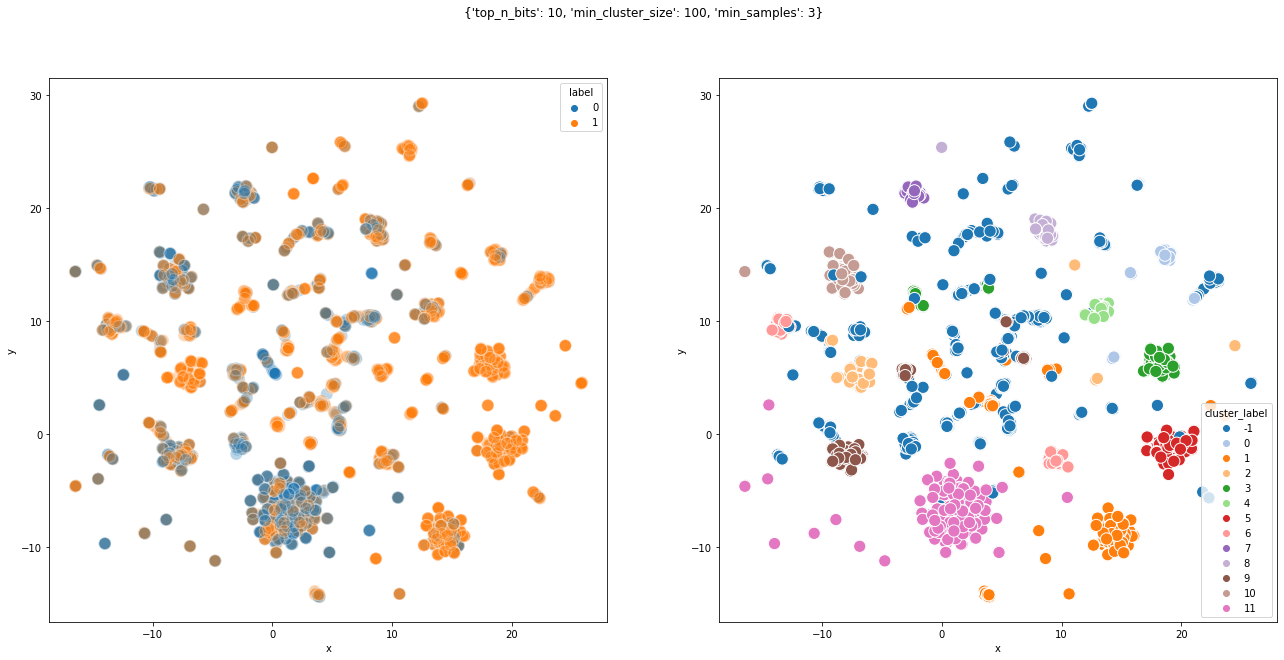

In [21]:
hparams = {
    'top_n_bits': 10,
    'min_cluster_size': 100,
    'min_samples': 3
}

# get top N most important bits
top_n_bits = get_top_bits(shap_explanation.values, n=hparams['top_n_bits'])

# subset dataset
top_bit_features = np.stack([train_X[:, bit_num] for bit_num in top_n_bits], axis=1)
top_bit_features.shape

# cluster
clusterer = hdbscan.HDBSCAN(min_cluster_size=hparams['min_cluster_size'],
                            min_samples=hparams['min_samples'],
                            gen_min_span_tree=True)
clusterer.fit(top_bit_features)
pred_cluster = clusterer.labels_

# redução de dimensão => visualização
reducer = umap.UMAP(n_neighbors=5, min_dist=0.3)
embeddings = reducer.fit_transform(top_bit_features)

#visualização
embeddings_df = pd.DataFrame({
    'label': train_y,
    'x': embeddings[:, 0],
    'y': embeddings[:, 1],
    'cluster_label': pred_cluster,
    'size': [500]*train_y.shape[0]
})

# plot embeddings from unormalized, one-hot values
fig, axs = plt.subplots(figsize=(22,10), ncols=2)
sns.scatterplot(data=embeddings_df, x='x', y='y', hue='label',
                s=150, alpha=.3, ax=axs[0]);
sns.scatterplot(data=embeddings_df, x='x', y='y', hue='cluster_label',
                palette='tab20', s=150, ax=axs[1]);
plt.suptitle('{}'.format(hparams));

In [22]:
def incidence(np_array):
    return np.mean(np_array, axis=0)


In [23]:
inhibitors = top_bit_features[(train_y == 1)]
non_inhibitors = top_bit_features[(train_y == 0)]
const_conversion = non_inhibitors.shape[0]/inhibitors.shape[0]

for cluster_id in set(pred_cluster):
    inhibitors = top_bit_features[(pred_cluster == cluster_id) & (train_y == 1)]
    non_inhibitors = top_bit_features[(pred_cluster == cluster_id) & (train_y == 0)]
    
    inhibitor_incidence = incidence(inhibitors)
    non_inhibitor_incidence = incidence(non_inhibitors)
    
    ratio = inhibitor_incidence/non_inhibitor_incidence
    cluster_size = inhibitors.shape[0] + non_inhibitors.shape[0]
    frac = len(inhibitors)/len(non_inhibitors)    
    
    if cluster_id == -1:
        print('cluster_id: outliers')    
    else:
        print('cluster_id:', cluster_id)
    print('Cluster size', cluster_size)
    print('#inhibitors/#non-inhibitors:', float('{:.2f}'.format(frac)))
    print('indicidence ratio', {i: 'bit não ativado' if np.isnan(r) else float('{:.2f}'.format(r)) for i, r in zip(top_n_bits, ratio)})
    print('-'*100)

cluster_id: 0
Cluster size 116
#inhibitors/#non-inhibitors: 18.33
indicidence ratio {1367: 1.19, 1226: inf, 1452: 1.0, 329: 1.0, 1928: 1.0, 1482: inf, 489: 1.0, 366: 0.93, 1077: 'bit não ativado', 650: 0.87}
----------------------------------------------------------------------------------------------------
cluster_id: 1
Cluster size 455
#inhibitors/#non-inhibitors: 4.35
indicidence ratio {1367: 1.38, 1226: 1.07, 1452: 1.0, 329: 2.45, 1928: 0.46, 1482: 2.6, 489: 1.0, 366: 1.4, 1077: 0.06, 650: 1.0}
----------------------------------------------------------------------------------------------------
cluster_id: 2
Cluster size 148
#inhibitors/#non-inhibitors: 28.6
indicidence ratio {1367: 4.72, 1226: 0.99, 1452: 1.0, 329: 1.63, 1928: 1.0, 1482: inf, 489: 1.0, 366: 1.0, 1077: 'bit não ativado', 650: 'bit não ativado'}
----------------------------------------------------------------------------------------------------
cluster_id: 3
Cluster size 232
#inhibitors/#non-inhibitors: 37.67
indicid

divide by zero encountered in true_divide
invalid value encountered in true_divide


**Interpretando resultados**

De acordo com essa última clusterização, os grupos mais bem definidos de inibidores são: 2,3 e 5. Os outros clusters têm uma relação entre inibidores/não-inibidores relativamente baixa. Em particular, os clusters 6 e 11 são os que têm as menores proporções inibidores/não-inibidores. Desse modo podemos realizar uma análise comparativa dos clusters 2,3 e 5  contra os 6 e 11.

### Análise Comparativa dos Clusters

##### Clusters com mais inibidores

**Cluster 2 - indicidence ratio:**

{1367: 4.72, 1226: 0.99, 1452: 1.0, 329: 1.63, 1928: 1.0,  1482: inf,   489: 1.0, 366: 1.0, 1077: 'bna', 650: 'bna'}


**Cluster 3 - indicidence ratio:**

{1367: 2.89, 1226: 1.0, 1452: 1.0,  329: 1.0, 1928: 1.0,   1482: 0.56,  489: 1.2, 366: 1.1, 1077: 'bna', 650: 1.0}

**Cluster 5 - indicidence ratio:**

{1367: 1.0, 1226: 1.0,  1452: 1.0,  329: 1.0, 1928: 'bna', 1482: 'bna', 489: 1.0, 366: 'bna', 1077: inf, 650: 'bna'}


##### Clusters com mais não-inibidores

**Cluster 7 - indicidence ratio:**

{1367: 'bna', 1226: 'bna', 1452: 1.0, 329: 'bna', 1928: 'bna', 1482: 'bna', 489: 'bna', 366: 'bna', 1077: 'bna', 650: 'bna'}

**Cluster 11 - indicidence ratio:**

{1367: 'bna', 1226: 'bna', 1452: 'bna', 329: 'bna', 1928: 'bna', 1482: 'bna', 489: 'bna', 366: 'bna', 1077: 'bna', 650: 1.0}


onde **bna** significa bit não ativado


Podemos observar que o bit ***1367*** não é ativado nos clusters com mais não-inibidores, enquanto que ele tem uma inicidência >= 1 para os clusters com maioria de inibidores, isso indica que esse bit têm importância significativa para caracterizarição de inibidores. Além disso, podemos ver que apenas os bits ***1452*** e ***650*** não ativados dentre os clusters majoritatimente não-inibidores, e a incidência é igual a 1, ao passo que eles ou não são ativados dentre os inibidores ou também têm indicidência 1. Isso indica que esses bits não são suficientes para classificar os não-inidores. Analogamente, os bits ***1928*** e ***650*** não são suficientes para explicar os inibidores dos clusters 2, 3 e 5.

Já os bits ***329*** e ***1482*** são relevantes para a classificação de inibidores dentro do cluster 2, mas não dentro dos clusters 3 e 5. O bit ***1482*** parece ser importante para classificar os não-inibidores do cluster 3 e os inibidores do cluster 2. Por fim, o bit ***1077*** é relevante para a classificação de inibidores dentro do cluster 5.


**Resumo:**

Cluster 2 é caracterizado pelos bits: ***1367***, ***329*** e ***1482***

Cluster 3 é caracterizado pelos bits: ***1367***, ***1482*** e ***489***

Cluster 5 é caracterizado pelos bits: ***1077***


Assim, vamos analisar os trechos de moléculas codificados pelos bits:
***1367***, ***329***, ***1482***, ***489*** e ***1077***.

Bit 1367 ----------------------------------------------


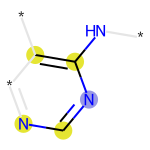

Bit 329 -----------------------------------------------


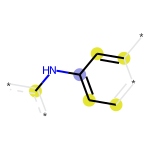

Bit 1482 ----------------------------------------------


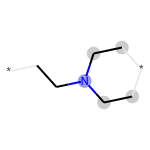

Bit 489 -----------------------------------------------


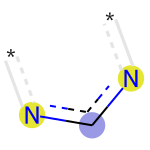

Bit 1077 ----------------------------------------------


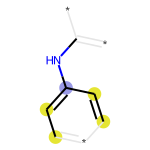

In [24]:
for bit_num in [1367, 329, 1482, 489, 1077]:
    search_bit = str(bit_num)
    print('Bit {}'.format(search_bit), '-'*(50 - len(search_bit)))

    # get bit info corresponding to it
    chemblid, bi = [(_id, bit_info) for _id, bit_info in chembl_to_bitinfo.items()
                    if search_bit in list(bit_info.keys())][0]
    
    search_mol = get_mol(chemblid, df_smiles)
    bit_img = Draw.DrawMorganBit(search_mol, search_bit, bi, useSVG=True)
    display(bit_img)

### Listando e visualizando moleculas de acordo com seus clusters e label

In [84]:
def list_molecules_by_cluster(target_cluster, pred_dataset, raw_chembl, labels):
    '''
    INPUT:
    target_cluster: cluster que se deseja analisar
    pred_dataset: dataset com a lista de moleculas e seus respectivos clusters
    raw_chembl: dataset com a lista de moleculas com seus respetivos Chembl_Id
    labels: dataset com a lista de labels
    OUTPUT:
    target_chembl_cluster: lista com o cluster alvo (para criação de DataFrame)
    target_chembl_ids: lista de Chembl_Ids da moleculas pertencentes ao cluster alvo
    target_chembl_labels: lista de labels dos Chembl_Ids listados
    '''
    #1. list indexes of the molecules in the pred_dataset that belong to the target_cluster
    target_molecules_indexes = []
    for molecule_index, cluster in enumerate(pred_dataset):
        if cluster == target_cluster:
            target_molecules_indexes.append(molecule_index)
            
    #2. list the chembl ids and labels of the target molecules
    target_chembl_ids = []
    target_chembl_labels = []
    target_chembl_cluster = []
    
    for molecule_index in target_molecules_indexes:
        target_chembl_ids.append(raw_chembl_ids[molecule_index])
        target_chembl_labels.append(train_y[molecule_index])
        target_chembl_cluster.append(target_cluster)
    
    return target_chembl_cluster, target_chembl_ids, target_chembl_labels

def visualize(chembl_id):
    # Fetch data from website and returns the smiles notation. Input = Chembl Id, Output = Smiles notation
    molecule = new_client.molecule
    smiles = molecule.get(chembl_id)['molecule_structures']['canonical_smiles']
    display(Chem.MolFromSmiles(smiles))
    return None
    

In [85]:
#Carregando os Chembl_Ids sem alteração
#como os índices foram preservados, é uma forma de recuperação dos dados originais

raw_chembl_ids = np.load(sys.path[-1] + '/data/raw/train/train_ids.npy', allow_pickle = True)

In [86]:
#Criando DataFrame de targte_clusters com chembl_id e label para análise

target_clusters = [2, 3, 5, 7, 11]

molecule_cluster = []
chembl_id = []
label = []

for cluster in target_clusters:
    add_chembl_cluster, new_chembl_ids, new_labels = list_molecules_by_cluster(cluster, pred_cluster, raw_chembl_ids, train_y)
    molecule_cluster.extend(add_chembl_cluster)
    chembl_id.extend(new_chembl_ids)
    label.extend(new_labels)

cluster_df = pd.DataFrame({'cluster':molecule_cluster, 'chembl_id': chembl_id, 'label':label})
#cluster_df.to_csv('/Users/leonardoyamaguishi/datasci4heatlh/data/cluster_chembl_label.csv')

In [87]:
def filter_cluster_df(cluster_df, target_cluster, target_label = None):
    if target_label == None:
        return cluster_df[(cluster_df['cluster'] == target_cluster)]
    else:
        return cluster_df[(cluster_df['cluster'] == target_cluster) & (cluster_df['label'] == target_label)]
    return None

In [88]:
cluster_desejado = 2
label_desejado = 0 #None para não filtrar por label
filter_cluster_df(cluster_df, cluster_desejado, label_desejado)

,cluster,chembl_id,label
17,2,CHEMBL1278148,0
42,2,CHEMBL1683957,0
90,2,CHEMBL1928953,0
119,2,CHEMBL1278056,0
128,2,CHEMBL1683953,0


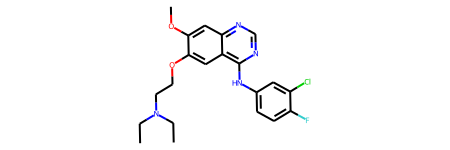

In [89]:
#Exemplo de molécula inibidora pertencente ao Cluster 2 
visualize('CHEMBL293064')

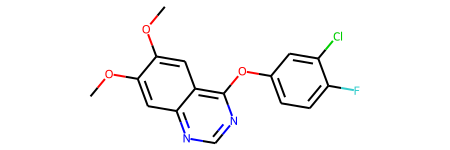

In [90]:
#Exemplo de molécula não inibidora pertencente ao Cluster 2 
visualize('CHEMBL1278148')

### Interpretação da seleção de bits com uma abordagem determinística
A partir dos bits 1367, 329, 1482, 489 e 1077 que, dentro dos clusters, apresentaram maior incidência para moléculas inibidoras, torna-se possível uma validação da acurácia desta constatação no dataset de teste.

In [227]:
from sklearn.metrics import confusion_matrix
def extracted_knowledge_validation(training_dataset, target_bits, expected_results):
    prediction = []
    
    for molecule_fp in training_dataset:
        inhibit = 1
        for bit in target_bits:
            if molecule_fp[bit] != target_bits[bit]:
                inhibit = 0
        prediction.append(inhibit)
    
    prediction = np.array(prediction)
    
    acc = (sum(expected_results == prediction))/len(expected_results)
    
    c_m = confusion_matrix(expected_results, prediction)
    sensibility = c_m[1,1]/sum(expected_results == 1)
    specificity = c_m[0,0]/sum(expected_results == 0)
    
    return acc, c_m, sensibility, specificity

In [228]:
#Bits ativados somente em moléculas não inibidoras
non_inhibiting_bits = [17, 85, 187, 188,538, 545, 604, 651, 856, 1091, 1115, 1117, 1202, 1229, 1247, 1307, 1371, 1414, 1428, 1438, 1606, 1870, 1880, 1904, 1943]

only_non_inhibiting_dict = {}

for bit in non_inhibiting_bits:
    only_non_inhibiting_dict[bit] = 0

In [229]:
selected_inhibiting_dict_1 = {1367 : 1, 329 : 1, 1482 : 1, 489 : 1, 1077 : 1}
selected_inhibiting_dict_2 = {1367 : 1, 329 : 1, 1482 : 1, 489 : 1}
selected_inhibiting_dict_3 = {1367 : 1, 329 : 1, 1482 : 1}
selected_inhibiting_dict_4 = {1367 : 1, 1482 : 1}
selected_inhibiting_dict_5 = {1367 : 1, 329 : 1, 1482 : 1, 489 : 1, 650: 0}

testing_condition_list = [selected_inhibiting_dict_1,
                          selected_inhibiting_dict_2, 
                          selected_inhibiting_dict_3,
                          selected_inhibiting_dict_4,
                          selected_inhibiting_dict_5,
                          only_non_inhibiting_dict]

#Preparo de um DataFrame para visualização dos resultados
testing_condition = []
acc_list = []
c_m_list= []
sensibility_list = []
specificity_list = []


for test in testing_condition_list:
    acc, c_m, sensibility, specificity = extracted_knowledge_validation(test_X, test, test_y)
    
    #Registro no DataFramne
    testing_condition.append(test)
    acc_list.append(acc)
    c_m_list.append(c_m)
    sensibility_list.append(sensibility)
    specificity_list.append(specificity)

testing_condition_df = pd.DataFrame({'test':testing_condition,  
                                     'c_m' : c_m_list,
                                     'accuracy' : acc_list,
                                     'sensibility': sensibility_list,
                                     'specificity':specificity_list
                                    })

In [230]:
testing_condition_df

,test,c_m,accuracy,sensibility,specificity
0,"{1367: 1, 329: 1, 1482: 1, 489: 1, 1077: 1}","[[324, 0], [711, 0]]",0.313043,0.000000,1.000000
1,"{1367: 1, 329: 1, 1482: 1, 489: 1}","[[324, 0], [693, 18]]",0.330435,0.025316,1.000000
2,"{1367: 1, 329: 1, 1482: 1}","[[324, 0], [693, 18]]",0.330435,0.025316,1.000000
3,"{1367: 1, 1482: 1}","[[321, 3], [683, 28]]",0.337198,0.039381,0.990741
4,"{1367: 1, 329: 1, 1482: 1, 489: 1, 650: 0}","[[324, 0], [703, 8]]",0.320773,0.011252,1.000000
5,"{17: 0, 85: 0, 187: 0, 188: 0, 538: 0, 545: 0,...","[[4, 320], [0, 711]]",0.690821,1.000000,0.012346


Ao direcionar a busca pelos bits mais relevantes com maior incidência em proteínas inibidoras, foi obtida uma acurácia média de 32,8% apresentando alta contagem de falsos negativos. Isso ocorre devido à alta variedade de trechos de proteína que podem caracterizar a capacidade inibidora da molécula como um todo. Esta acurácia é um indicativo de que os padrões observados têm o potencial de discriminar uma proteína inibidora de uma proteína não-inibidora, embora as condições encontradas não sejam exclusivas. <br/><br/>

Por outro lado, ao direcionar a busca pelos bits incidentes somente em moléculas não-inibidoras, foi obtida uma quantidade alta de falsos positivos, porque, para que uma molecula não seja inibidora, ela não necessariamente precisa ter todos os trechos listados ativados. <br/><br/>

De fato, esta é uma análise determinística com alto viés quando comparada, por exemplo, com um algoritmo de classificação de aprendizado de máquina. Como resultado disso, as condições de teste selected_inhibiting_dict_2, 3 e 4 foram tentativas de diminução de viés que aumentaram a acurácia e sensibilidade dos ensaios a custo de uma pequena diminuição da especificidade, o que indica que, dos bits selecionados, os bits mais significativos para descrever o comportamento inibidor de uma proteína são os bits 1367 e 1482. <br/><br/>

Por fim, os padrões moleculares idenfiticados apresentam potencial de discriminar uma proteína inibidora de uma proteína não-inibidora de forma não exclusiva, além disso há a oportunidade de redução de falsos positivos e falsos negativos a partir da definição de critérios mais abrangentes e menos enviesados, além do estudo dos trechos de moléculas mais relevantes para que uma proteína seja não-inibidora.